In [1]:
import sys
sys.path.insert(1, '/home/dpr/mmc_genomics/src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from denoise import denoise

In [3]:
chroms = ['2L', '2R', '3L', '3R']
recomb_dir = "../data/recombination_maps/Comeron_tables/"
maf_dir = '/project/jnovembre/data/external_public/DPGP3/'

# Recombination map

Import recombination map and apply the wavelet denoising procedure.

In [4]:
wavelet = 'db4'
t = 4.5

W = []
R_raw = []
R = []
for chrom in chroms:
    w_start_r, r_raw = np.loadtxt(recomb_dir +
                                  'Comeron_100kb_chr{}.txt'.format(chrom), unpack=True)
    min_r = min(r_raw[r_raw>0])
    rem, recomb_norm = np.modf(r_raw / min_r)
    r_denoised = denoise(recomb_norm, t=t, wavelet=wavelet)*min_r
    W.append(w_start_r)
    R_raw.append(r_raw)
    R.append(r_denoised)

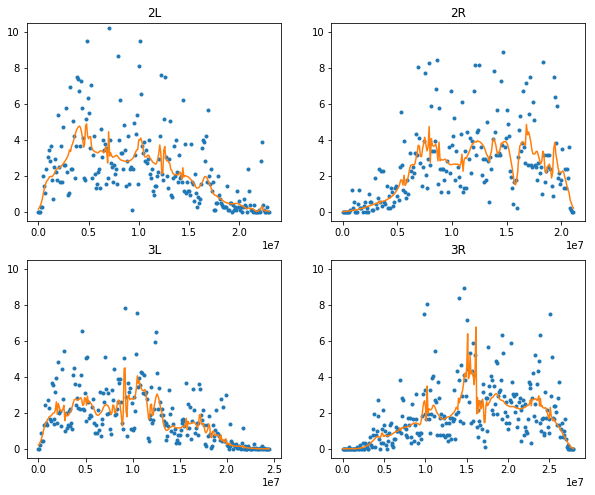

In [5]:
fig = plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.plot(W[i], R_raw[i],'.')
    ax.plot(W[i], R[i])
    ax.set_ylim([-0.5,10.5])
    ax.set_title(chroms[i])
plt.show()

We'll want to choose recombination rate cut-offs for our bins, so let's look at a histogram of $r$.

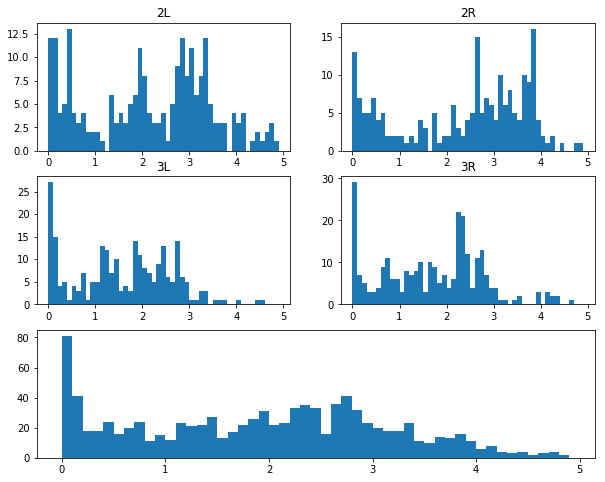

In [6]:
fig = plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(3,2,i+1)
    ax.hist(R[i], bins=np.arange(0,5,0.1))
    ax.set_title(chroms[i])
ax = plt.subplot(3,1,3)
ax.hist(np.concatenate(R), bins=np.arange(0,5,0.1))
plt.show()

The distribution is fairly uniform for $r>0$, so a reasonable starting-point might be uniform bins with $\Delta r = 1.0$ starting at $r=0.5$.

In [7]:
r_bins = np.arange(0.5,5.0,1.0)
print(np.histogram(np.concatenate(R), bins=r_bins))

(array([191, 255, 238,  89]), array([ 0.5,  1.5,  2.5,  3.5,  4.5]))


Let's see how these bins are distributed along the genome. We don't want any bin to be too localized in a single place.

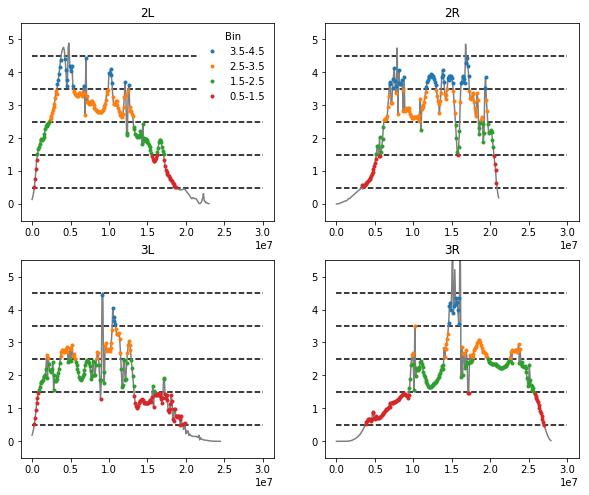

In [8]:
fig = plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    w = W[i]
    r = R[i]
    ax.plot(w,r,'-',c='0.5')
    for j in range(4)[::-1]:
        in_bin = np.logical_and(r >= r_bins[j], r < r_bins[j+1])
        ax.plot(w[in_bin], r[in_bin],'.', label='{}-{}'.format(r_bins[j], r_bins[j+1]))
    ax.hlines(r_bins, 0, 3e7, linestyle='dashed')
    ax.set_ylim([-0.5,5.5])
    ax.set_title(chroms[i])
    if i == 0:
        ax.legend(title='Bin', facecolor='w', edgecolor='w', framealpha=1.0)
plt.show()

Seems reasonably well-distributed. We should revisit this point later. Ideally, we'll go to some sort of continuous version rather than discrete bins.

# Diversity data

First, we'll test everything on a single chromosome arm. Chr2R seems like it has a good distribution of $r$, so we'll start there. First, import the minor allele frequency at each site.

In [9]:
test_chrom = '2R'
maf = np.loadtxt(maf_dir + 'Chr{}.maf.txt.gz'.format(test_chrom), dtype='float16')

In [10]:
w = W[1]
r = R[1]
print(w.shape, r.shape)
n_windows = len(w)

(212,) (212,)


In [11]:
n_bins = len(r_bins)-1
in_bins = np.empty((n_bins,n_windows), dtype=bool)
for i in range(n_bins):
    in_bins[i,:] = np.logical_and(r >= r_bins[i], r < r_bins[i+1])

To correspond with the recombination map, want to reshape the MAF vector into a 2D array corresponding to the 100kb windows of the r map.

In [12]:
dw = 100000
l_pad = dw - len(maf)%dw
maf_loci = np.pad(maf, (0,l_pad), 'constant', constant_values=np.nan).reshape((-1, dw))
print(maf_loci.shape)

(212, 100000)


As a sanity check, let's calculate some basic diversity statistics.

In [13]:
n_samples = 100
max_maf = n_samples//2
freqs = np.arange(max_maf + 1)
pi_weights = 2.0*freqs*(n_samples-freqs)/(n_samples**2)

First, we'll get the site frequency spectrum in windows, which will allow us to get the global SFS and $\pi$ as well as $\pi$ in windows.

In [14]:
sfs_windows = np.empty((n_windows, max_maf+1))
for i in range(n_windows):
    data = maf_loci[i,:]
    sfs_windows[i,:] = np.histogram(data[~np.isnan(data)], bins=np.arange(max_maf + 2))[0]

In [15]:
sfs_total = np.sum(sfs_windows, axis=0)/np.sum(sfs_windows)
pi_total = np.dot(pi_weights, sfs_total)
print('Global pi = {:.4f}'.format(pi_total))

Global pi = 0.0068


First, let's compare the global site frequency spectrum to its neutral, constant $N$ expectation:

In [16]:
sfs_neut = pi_total * (1.0/freqs + 1.0/(n_samples-freqs))
sfs_neut[0] = 1.0 - np.sum(sfs_neut[1:])

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Check that the two distributions have the same $\pi$.

In [17]:
print('Observed:', np.dot(sfs_total, pi_weights))
print('Expected:', np.dot(sfs_neut, pi_weights))

Observed: 0.0068145044641
Expected: 0.0068145044641


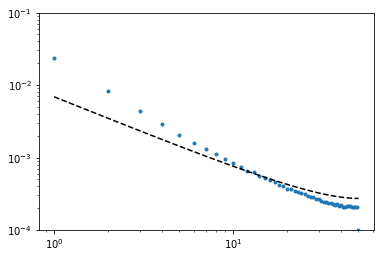

In [18]:
plt.loglog(sfs_total, '.')
plt.loglog(freqs, sfs_neut, '--k')
plt.ylim([1e-4, 1e-1])
plt.show()

There's a clear over-abundance of rare alleles in the data compared to expectation.

Now, let's see how diversity varies along the chromosome:

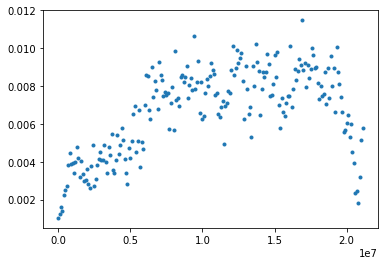

In [19]:
pi_windows = np.dot(sfs_windows, pi_weights)/np.sum(sfs_windows,axis=1)
plt.plot(w, pi_windows,'.')
plt.show()

And how $\pi$ varies with $r$, continuously and with our proposed binning scheme:

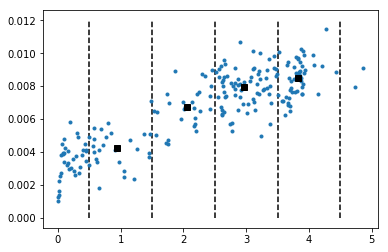

In [20]:
r_means = np.zeros(n_bins)
pi_means = np.zeros(n_bins)
for i in range(n_bins):
    in_bin = in_bins[i,:]
    r_means[i] = np.mean(r[in_bin])
    pi_means[i] = np.mean(pi_windows[in_bin])
    
plt.plot(r, pi_windows, '.')
plt.vlines(r_bins,0,0.012, linestyle='dashed')    
plt.plot(r_means, pi_means, 'sk')
plt.show()

In [21]:
print(r_means)
print(pi_means)

[ 0.93959453  2.04965577  2.96985762  3.82122277]
[ 0.00425065  0.00670976  0.00793903  0.00847898]


We can calculate $\pi$ and the site frequency spectrum in each of our $r$ bins and compare the latter to neutral, constant $N$ expectation given the former.

In [22]:
sfs_bins = np.zeros((n_bins, max_maf+1))
for i in range(n_bins):
    sfs_bins[i] = np.sum(sfs_windows[in_bins[i]], axis=0)
    sfs_bins[i] /= np.sum(sfs_bins[i])
    
pi_bins = np.dot(sfs_bins, pi_weights)
print(pi_bins)

[ 0.00423087  0.00669346  0.00790898  0.00846921]


In [23]:
sfs_neut_bins = pi_bins[:,None] * (1.0/freqs[None,:] + 1.0/(n_samples-freqs[None,:]))
sfs_neut_bins[:,0] = 1.0 - np.sum(sfs_neut_bins[:,1:],axis=1)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


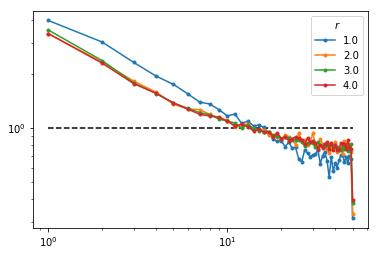

In [24]:
for i in range(n_bins):
    plt.loglog(sfs_bins[i,:] / sfs_neut_bins[i,:], '.-', label=r_bins[i]+.5)
#plt.ylim([1e-3,1])
plt.hlines(1,1,50, linestyle='dashed')
plt.legend(title='$r$')
plt.show()

The lowest-$r$ bin has the most SFS distortion, but there's no signal among the other bins.

# Joint site frequency spectra

We're going to calulate the 2-site joint site frequency spectrum as a function of the distance $d$ between the two sites. That means we have to define some parameters: the values of $d$ to examine and $\Delta d$, the range of $d$ to integrate over in order to reduce sampling noise.

In [25]:
d_list = [3, 10, 30, 100, 300, 1000]
delta_d = 10

in_bin = np.logical_or(in_bins[1], in_bins[2])
# Calculate joint site frequency spectrum from d to d+delta_d
Jsfs = np.zeros((len(d_list), max_maf+1, max_maf+1))
for i_d, d_start in enumerate(d_list):
    for d in range(d_start, d_start+delta_d):
        pairs = np.empty((np.count_nonzero(in_bin), dw-d, 2))
        pairs[:,:,0] = maf_loci[in_bin, :-d]
        pairs[:,:,1] = maf_loci[in_bin, d:]
        pairs = pairs.reshape((-1,2))
        pairs_safe = pairs[~np.isnan(np.sum(pairs,axis=1))]
        Jsfs[i_d,:,:] += np.histogram2d(pairs_safe[:,0], pairs_safe[:,1],
                                      np.arange(max_maf + 2))[0]
Jsfs += np.transpose(Jsfs, axes=(0,2,1))
Jsfs /= np.nansum(Jsfs, axis=(1,2))[:,None,None]
# Get the marginal site frequency spectrum
Msfs = np.nansum(Jsfs,axis=2)

Check that we didn't mess up the marginal sfs and that it's the same for different distances.

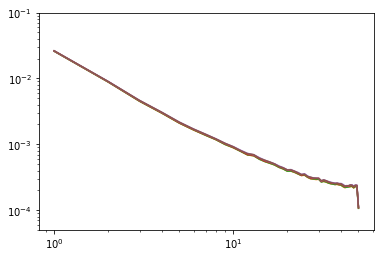

In [26]:
plt.loglog(Msfs.T)
plt.ylim([5e-5,1e-1])
plt.show()

Calculate pointwise mutatual information, mutual information, and $\pi$. Note that $I$ scales like $\pi^2$.

In [27]:
PMI = np.log2(Jsfs / (Msfs[:,:,None]*Msfs[:,None,:]))
MI = np.nansum(Jsfs*PMI, axis=(1,2))
pi_d = np.dot(Msfs, pi_weights)
print(MI)
print(pi_d)
print(MI/pi_d**2)

[  5.07556928e-04   2.90173736e-04   1.72459552e-04   6.95995848e-05
   3.34516707e-05   2.96532615e-05]
[ 0.00733482  0.00725034  0.00727318  0.00741805  0.00756064  0.00751702]
[ 9.43421392  5.5200235   3.26015728  1.2648167   0.58519512  0.52478455]


/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


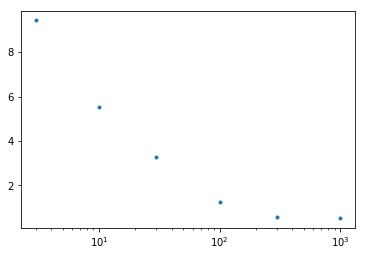

In [28]:
plt.semilogx(d_list, MI/pi_d**2, '.')
plt.show()

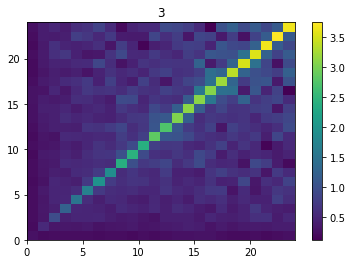

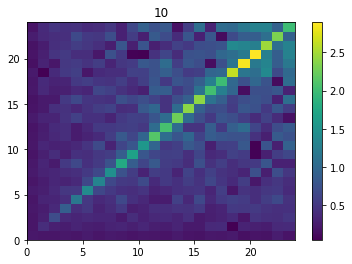

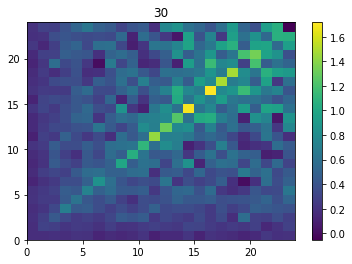

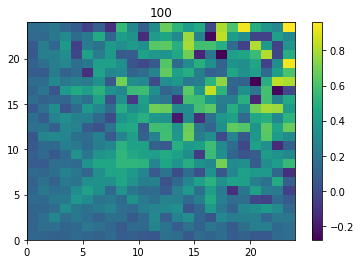

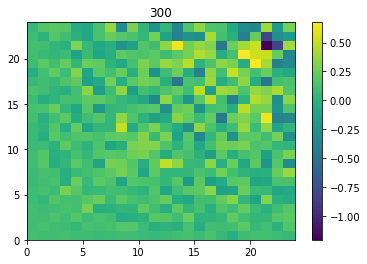

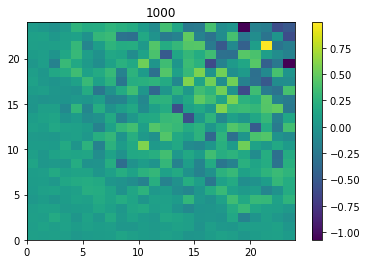

In [29]:
for i_d, d in enumerate(d_list):
    plt.pcolor(PMI[i_d,1:25,1:25])
    plt.title(d)
    plt.colorbar()
    plt.show()

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


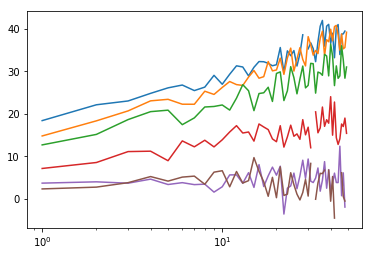

In [30]:
plt.semilogx((np.sum(PMI[:,1:,1:], axis=1)-np.diagonal(PMI[:,1:,1:],axis1=1,axis2=2)).T)
#plt.semilogx(np.nanmean(PMI[1:,1:],axis=1))
plt.show()

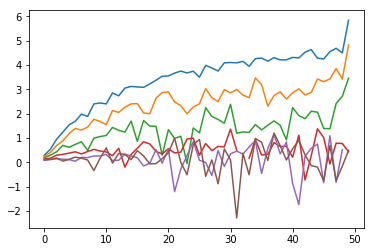

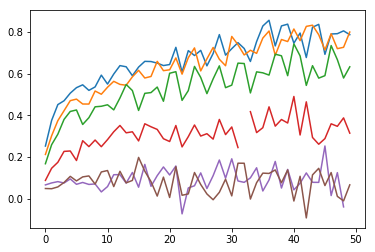

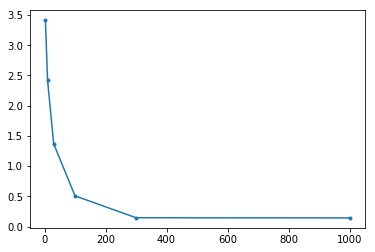

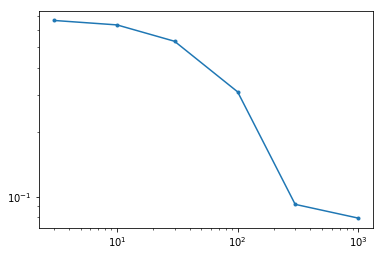

In [31]:
PMI_clean = np.copy(PMI[:,1:,1:])
PMI_clean[np.isinf(PMI[:,1:,1:])] = np.nan
diag = np.diagonal(PMI_clean, axis1=1, axis2=2)
offdiag = (np.nansum(PMI_clean, axis=2) - diag) / (n_samples/2 - 1)
plt.plot(diag.T)
plt.show()
plt.plot(offdiag.T)
plt.show()
plt.plot(d_list, np.nanmean(diag, axis=1), '.-')
plt.show()
plt.loglog(d_list, np.nanmean(offdiag, axis=1), '.-')
plt.show()

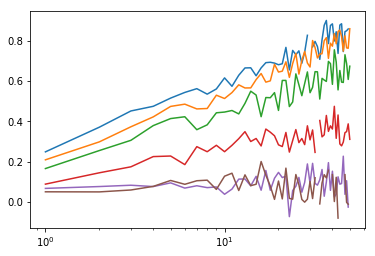

In [32]:
plt.semilogx(np.nanmean(PMI, axis=1).T)
#plt.semilogx(np.nanmean(PMI[1:,1:],axis=1))
plt.show()

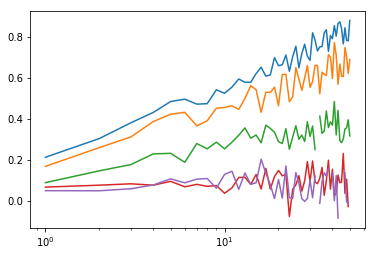

In [33]:
plt.semilogx(np.nanmean(PMI[1:,1:].T, axis=1))
plt.show()

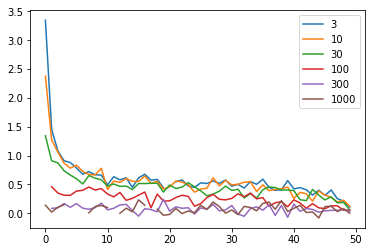

In [34]:
for i_d, d in enumerate(d_list):
    diag = np.zeros(50)
    for i in range(50):
        diag[i] = np.nanmean(PMI[i_d,:,:].diagonal(offset=i))
    plt.plot(diag,label=d)
#plt.ylim([0,1])
plt.legend()
plt.show()
#print(diag[0])

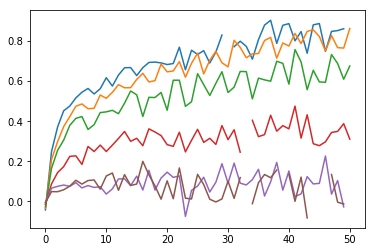

In [35]:
plt.plot(np.nanmean(PMI.T, axis=1))
#plt.semilogx(np.nanmean(PMI[1:,1:],axis=1))
plt.show()

# JSFS vs. $r$

In [55]:
#d_list = [3, 6, 10, 15, 20, 25, 30, 60, 100, 300, 1000, 3000, 10000]
d_list = np.logspace(1,4,13, dtype=int)
delta_d = 5

JSFS = np.zeros((n_bins, len(d_list), max_maf+1, max_maf+1))
# Loop over the r bins, get the boolean array in_bin
for i_bin, in_bin in enumerate(in_bins):
    # Calculate joint site frequency spectrum from d to d+delta_d
    for i_d, d_start in enumerate(d_list):
        for d in range(d_start, d_start+delta_d):
            pairs = np.empty((np.count_nonzero(in_bin), dw-d, 2))
            pairs[:,:,0] = maf_loci[in_bin, :-d]
            pairs[:,:,1] = maf_loci[in_bin, d:]
            pairs = pairs.reshape((-1,2))
            pairs_safe = pairs[~np.isnan(np.sum(pairs,axis=1))]
            JSFS[i_bin,i_d,:,:] += np.histogram2d(pairs_safe[:,0], pairs_safe[:,1],
                                                  np.arange(max_maf + 2))[0]
JSFS += np.transpose(JSFS, axes=(0,1,3,2))
JSFS /= np.nansum(JSFS, axis=(2,3))[:,:,None,None]

In [37]:
np.logspace(1,4,13, dtype=int)

array([   10,    17,    31,    56,   100,   177,   316,   562,  1000,
        1778,  3162,  5623, 10000])

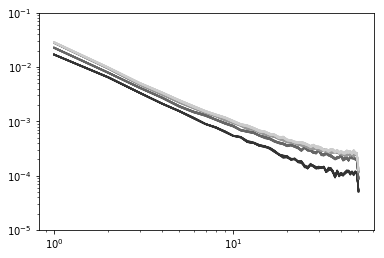

In [56]:
# Get the marginal site frequency spectrum
MSFS = np.nansum(JSFS,axis=3)

for i in range(n_bins):
    #print("r =",r_bins[i]+0.5)
    r = r_bins[i]+0.5
    plt.loglog(MSFS[i,:,:].T, color=str(r/5))
plt.ylim([1e-5,1e-1])
plt.show()

In [57]:
PMI = np.log2(JSFS / (MSFS[:,:,:,None]*MSFS[:,:,None,:]))
wPMI = JSFS*PMI
MI = np.nansum(JSFS*PMI, axis=(2,3))
PI = np.dot(MSFS, pi_weights)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
mu = 2.8e-9
a = 1e-8/(2*mu)

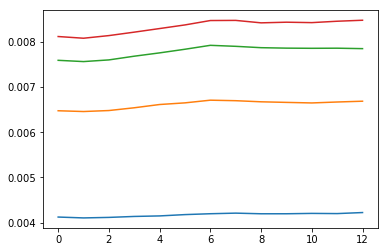

In [59]:
plt.plot(PI.T)
plt.show()

In [60]:
wPMI_clean = np.copy(wPMI[:,:,1:,1:])
wPMI_clean[np.isinf(wPMI[:,:,1:,1:])] = np.nan
diag = np.diagonal(wPMI_clean, axis1=2, axis2=3)
offdiag = (np.nansum(wPMI_clean, axis=3) - diag)

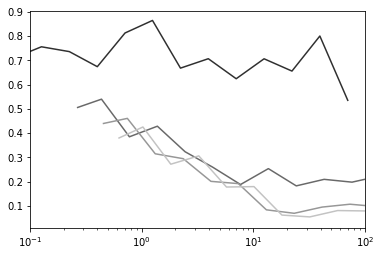

In [61]:
#plt.figure(figsize=(4,8))
for i in range(n_bins):
    #r = r_bins[i]+0.5
    r = r_means[i]
    
    #ax = plt.subplot(3,1,1)
    #plt.plot(np.array(d_list)+1, np.nanmean(offdiag[i,:,:], axis=1), color=str(r/5))

    #ax = plt.subplot(3,1,2)
    #plt.plot((np.array(d_list)+1)*r, np.nanmean(offdiag[i,:,:], axis=1), color=str(r/5))
    
    #ax = plt.subplot(3,1,3)
    plt.semilogx(a*(np.array(d_list)+1)*r*np.mean(PI[i,:]), np.nanmean(offdiag[i,:,:], axis=1)/np.mean(PI[i,:]**2), color=str(r/5))
    plt.xlim([0.1,100])
plt.show()

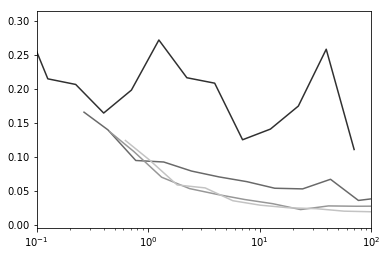

In [62]:
#plt.figure(figsize=(4,8))
for i in range(n_bins):
    #r = r_bins[i]+0.5
    r = r_means[i]
    
    #ax = plt.subplot(3,1,1)
    #plt.plot(np.array(d_list)+1, np.nanmean(offdiag[i,:,:], axis=1), color=str(r/5))

    #ax = plt.subplot(3,1,2)
    #plt.plot((np.array(d_list)+1)*r, np.nanmean(offdiag[i,:,:], axis=1), color=str(r/5))
    
    #ax = plt.subplot(3,1,3)
    plt.semilogx(a*(np.array(d_list)+1)*r*np.mean(PI[i,:]), np.nanmean(diag[i,:,:], axis=1)/np.mean(PI[i,:]**2), color=str(r/5))
    plt.xlim([0.1,100])
plt.show()

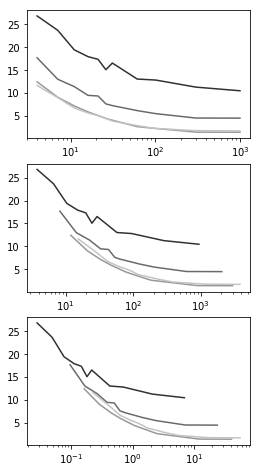

In [30]:
plt.figure(figsize=(4,8))
for i in range(n_bins):
    #r = r_bins[i]+0.5
    r = r_means[i]
    
    ax = plt.subplot(3,1,1)
    plt.semilogx(np.array(d_list)+1, MI[i,:]/PI[i,:]**2, color=str(r/5))

    ax = plt.subplot(3,1,2)
    plt.semilogx((np.array(d_list)+1)*r, MI[i,:]/PI[i,:]**2, color=str(r/5))
    
    ax = plt.subplot(3,1,3)
    plt.semilogx(a*(np.array(d_list)+1)*r*np.mean(PI[i,:]), MI[i,:]/PI[i,:]**2, color=str(r/5))
plt.show()

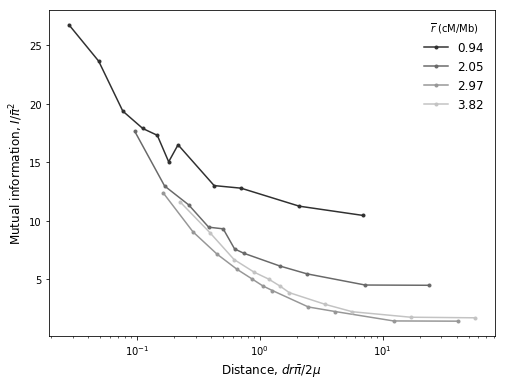

In [40]:
fig = plt.figure(figsize=(8,6))
for i in range(n_bins):
    x = a*(np.array(d_list)+1)*r_means[i]*np.mean(PI[i,:])
    c = str(r_means[i]/5)
    l = '{:.2f}'.format(r_means[i])
    plt.semilogx(x, MI[i,:]/PI[i,:]**2, '.-', color=c, label=l)
plt.legend(frameon=False, title=r'$\overline{r}$ (cM/Mb)', fontsize=12)
plt.xlabel(r'Distance, $d r \bar{\pi} / 2\mu$', fontsize=12)
plt.ylabel(r'Mutual information, $I/\bar{\pi}^2$', fontsize=12)
plt.show()

In [32]:
PMI_nan = np.copy(PMI)
PMI_nan[np.isinf(PMI_nan)] = np.nan

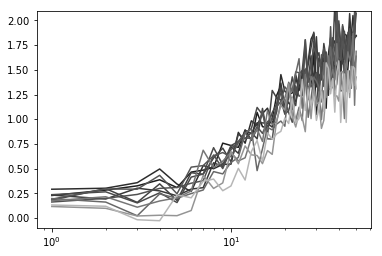

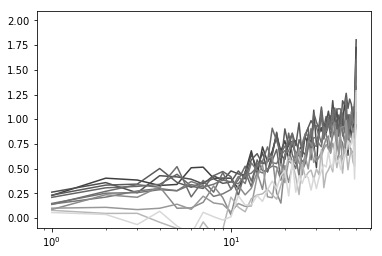

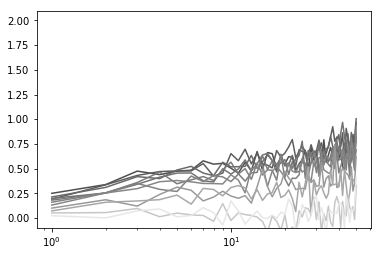

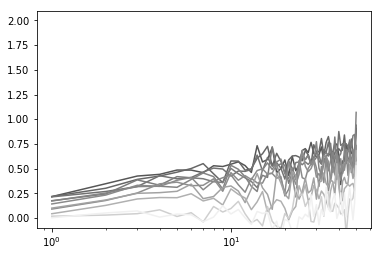

In [115]:
for i in range(n_bins):
    for j in range(len(d_list)):
        d_scaled = a*(d_list[j]+1)*r_means[i]*PI[i,j]
        c = str((np.log10(d_scaled)+2)/4)
        plt.semilogx(np.nanmean(PMI_nan[i,j,0:,0:], axis=1), color=c)
    plt.ylim([-0.1,2.1])
    plt.show()

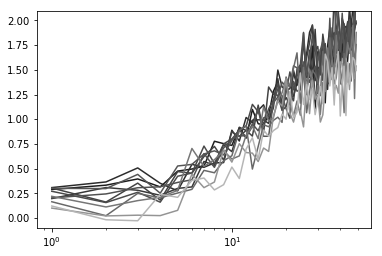

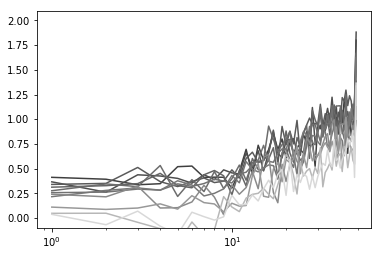

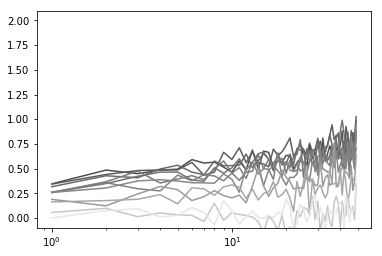

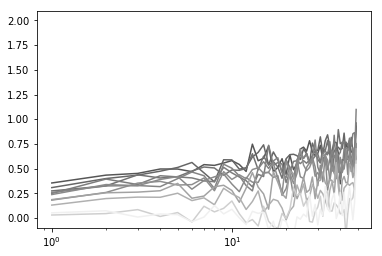

In [116]:
for i in range(n_bins):
    for j in range(len(d_list)):
        d_scaled = a*(d_list[j]+1)*r_means[i]*PI[i,j]
        c = str((np.log10(d_scaled)+2)/4)
        plt.semilogx(np.nanmean(PMI_nan[i,j,1:,1:], axis=1), color=c)
    plt.ylim([-0.1,2.1])
    plt.show()

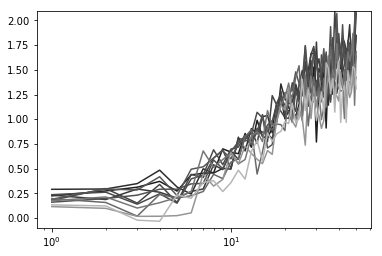

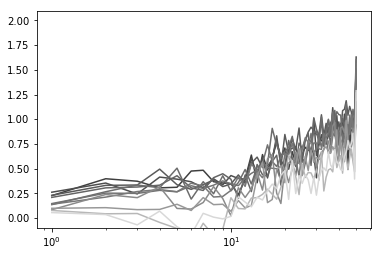

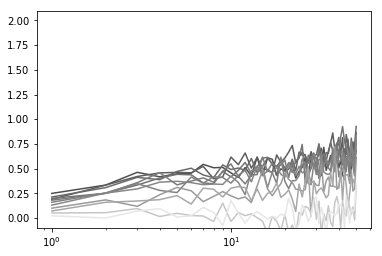

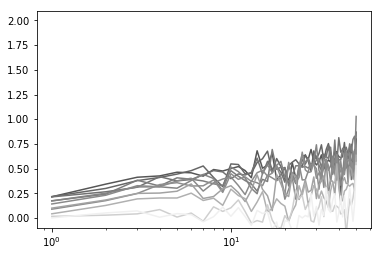

In [35]:
for i in range(n_bins):
    for j in range(len(d_list)):
        d_scaled = a*(d_list[j]+1)*r_means[i]*PI[i,j]
        c = str((np.log10(d_scaled)+2)/4)
        p = np.copy(PMI_nan[i,j,:,:])
        np.fill_diagonal(p,np.nan)
        plt.semilogx(np.nanmean(p, axis=1), color=c)
    plt.ylim([-0.1,2.1])
    plt.show()

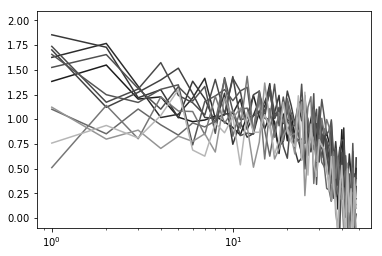

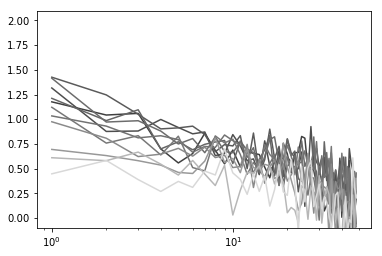

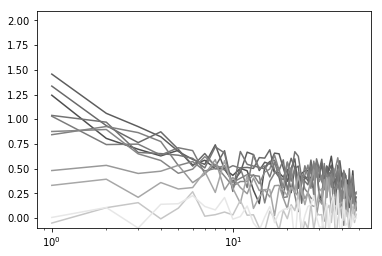

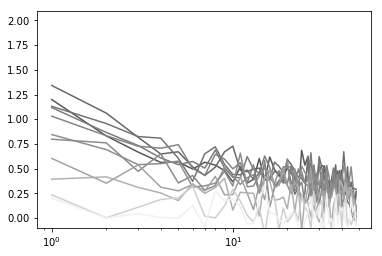

In [38]:
for i in range(n_bins):
    for j in range(len(d_list)):
        d_scaled = a*(d_list[j]+1)*r_means[i]*PI[i,j]
        c = str((np.log10(d_scaled)+2)/4)
        diag = np.array([np.nanmean(np.diagonal(PMI_nan[i,j,0:,0:],offset=o))
                         for o in range(max_maf-1)])
        plt.semilogx(diag, color=c)
    plt.ylim([-0.1,2.1])
    plt.show()

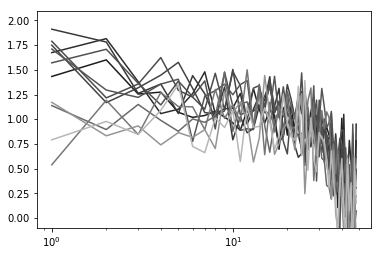

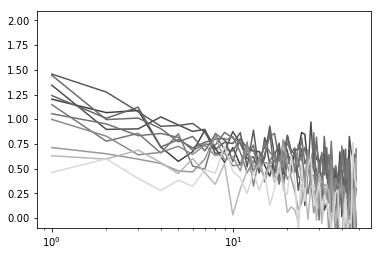

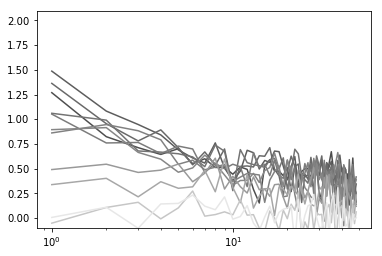

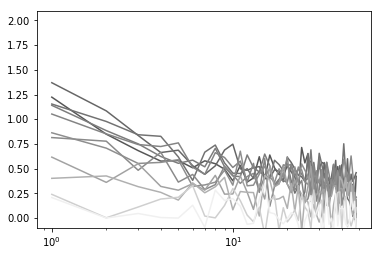

In [41]:
for i in range(n_bins):
    for j in range(len(d_list)):
        d_scaled = a*(d_list[j]+1)*r_means[i]*PI[i,j]
        c = str((np.log10(d_scaled)+2)/4)
        diag = np.array([np.nanmean(np.diagonal(PMI_nan[i,j,1:,1:],offset=o))
                         for o in range(max_maf-1)])
        plt.semilogx(diag, color=c)
    plt.ylim([-0.1,2.1])
    plt.show()

# All chromosomes

In [121]:
maf_dict = {}
for chrom in chroms:
    print("Importing chr{}...".format(chrom))
    maf_dict[chrom] = np.loadtxt(maf_dir + 'Chr{}.maf.txt.gz'.format(chrom), dtype='float16')

Importing chr2L...
Importing chr2R...
Importing chr3L...
Importing chr3R...


In [122]:
for c in chroms:
    print(len(maf_dict[c]))

23011544
21146708
24543557
27905053


In [123]:
for i in range(n_bins):
    print(r_bins[i], r_bins[i+1])

0.5 1.5
1.5 2.5
2.5 3.5
3.5 4.5


In [147]:
#dw = 100000
in_bins_dict = {}
maf_loci_dict = {}
for i_chr, chrom in enumerate(chroms):
    n_windows = len(W[i_chr])

    # Get boolean in_bins for each chromosome
    in_bins = np.empty((n_bins,n_windows), dtype=bool)
    for i_bin in range(n_bins):
        in_bins[i_bin,:] = np.logical_and(R[i_chr] >= r_bins[i_bin],
                                          R[i_chr] < r_bins[i_bin+1])
    in_bins_dict[chrom] = in_bins
    
    # Get the maf parsed into loci for each chromosome
    maf = maf_dict[chrom]
    l_pad = dw - len(maf)%dw
    maf_loci = np.pad(maf, (0,l_pad), 'constant', constant_values=np.nan).reshape((-1, dw))
    maf_loci_dict[chrom] = maf_loci

Chr2L pi = 0.0081


/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Chr2R pi = 0.0068
Chr3L pi = 0.0069
Chr3R pi = 0.0062


/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


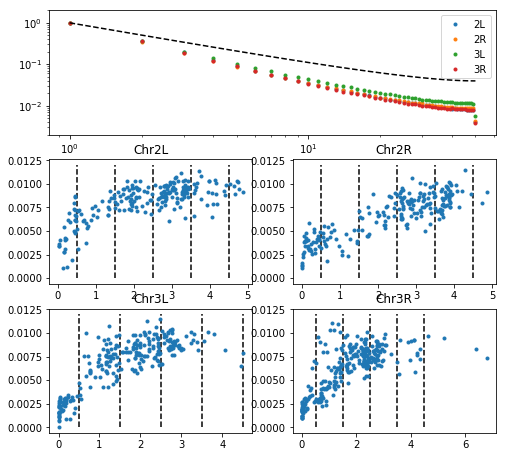

In [150]:
fig = plt.figure(figsize=(8,16))

for i_chr, chrom in enumerate(chroms):
    w = W[i_chr]
    r = R[i_chr]
    n_windows = len(w)
    maf_loci = maf_loci_dict[chrom]
    in_bins = in_bins_dict[chrom]

    sfs_windows = np.empty((n_windows, max_maf+1))
    for i_w in range(n_windows):
        data = maf_loci[i_w,:]
        sfs_windows[i_w,:] = np.histogram(data[~np.isnan(data)],
                                          bins=np.arange(max_maf + 2))[0]
        
    sfs_chrom = np.sum(sfs_windows, axis=0)/np.sum(sfs_windows)
    pi_chrom = np.dot(pi_weights, sfs_chrom)
    print('Chr{0} pi = {1:.4f}'.format(chrom, pi_chrom))
    
    #sfs_neut = pi_chrom * (1.0/freqs + 1.0/(n_samples-freqs))
    #sfs_neut[0] = 1.0 - np.sum(sfs_neut[1:])
    ax1 = plt.subplot(611)
    ax1.loglog(sfs_chrom/sfs_chrom[1], '.', label=chrom)
    
    #r_means = np.zeros(n_bins)
    #pi_means = np.zeros(n_bins)
    #for i in range(n_bins):
    #    in_bin = in_bins[i,:]
    #    r_means[i] = np.mean(r[in_bin])
    #    pi_means[i] = np.mean(pi_windows[in_bin])
        
    pi_windows = np.dot(sfs_windows, pi_weights)/np.sum(sfs_windows,axis=1)
    ax2 = plt.subplot(6,2,3+i_chr)    
    ax2.plot(r, pi_windows, '.')
    ax2.vlines(r_bins,0,0.012, linestyle='dashed')    
    #ax2.plot(r_means, pi_means, 'sk')
    ax2.set_title('Chr{}'.format(chrom))
    
sfs_neut = (1.0/freqs + 1.0/(n_samples-freqs))
sfs_neut /= sfs_neut[1]
ax1.loglog(freqs[1:], sfs_neut[1:], '--k')
ax1.set_ylim([2e-3, 2e0])
ax1.legend()
plt.show()

Chr2L has higher pi, the SFS Chr3L looks different from the others, and the relationship between pi and r looks a little different from chromosome to chromosome.

In [151]:
#d_list = [3, 6, 10, 15, 20, 25, 30, 60, 100, 300, 1000]
d_list = [3, 10, 30, 100]
delta_d = 3

jsfs_dict = {}
for chrom in chroms:
    in_bins = in_bins_dict[chrom]
    maf_loci = maf_loci_dict[chrom]
    JSFS = np.zeros((n_bins, len(d_list), max_maf+1, max_maf+1))
    # Loop over the r bins, get the boolean array in_bin
    for i_bin, in_bin in enumerate(in_bins):
        # Calculate joint site frequency spectrum from d to d+delta_d
        for i_d, d_start in enumerate(d_list):
            for d in range(d_start, d_start+delta_d):
                pairs = np.empty((np.count_nonzero(in_bin), dw-d, 2))
                pairs[:,:,0] = maf_loci[in_bin, :-d]
                pairs[:,:,1] = maf_loci[in_bin, d:]
                pairs = pairs.reshape((-1,2))
                pairs_safe = pairs[~np.isnan(np.sum(pairs,axis=1))]
                JSFS[i_bin,i_d,:,:] += np.histogram2d(pairs_safe[:,0], pairs_safe[:,1],
                                                      np.arange(max_maf + 2))[0]
    JSFS += np.transpose(JSFS, axes=(0,1,3,2))
    JSFS /= np.nansum(JSFS, axis=(2,3))[:,:,None,None]
    jsfs_dict[chrom] = JSFS

In [152]:
# Get the marginal site frequency spectrum
msfs_dict = {chrom : np.nansum(jsfs_dict[chrom],axis=3) for chrom in chroms}

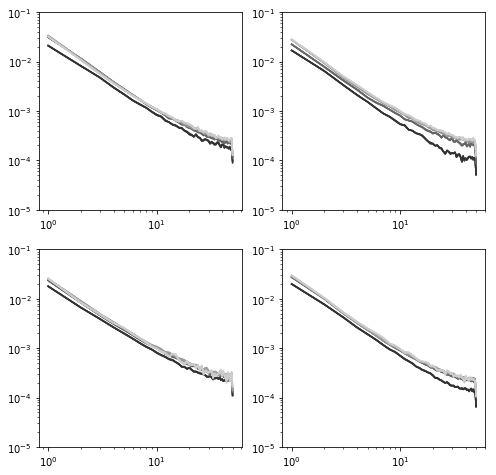

In [153]:
plt.figure(figsize=(8,8))
for i_chr, chrom in enumerate(chroms):
    ax = plt.subplot(2,2,i_chr+1)
    for i in range(n_bins):
        r = r_bins[i]+0.5
        plt.loglog(msfs_dict[chrom][i,:,:].T, color=str(r/5))
    plt.ylim([1e-5,1e-1])
plt.show()

In [154]:
pmi_dict = {}
mi_dict = {}
pi_dict = {}
for chrom in chroms:
    JSFS = jsfs_dict[chrom]
    MSFS = msfs_dict[chrom]
    pmi_dict[chrom] = np.log2(JSFS / (MSFS[:,:,:,None]*MSFS[:,:,None,:]))
    mi_dict[chrom] = np.nansum(JSFS*pmi_dict[chrom], axis=(2,3))
    pi_dict[chrom] = np.dot(MSFS, pi_weights)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys
/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


2L
[[ 0.00656294  0.00641461  0.00637873  0.00647906]
 [ 0.00839851  0.00817872  0.00814845  0.00834778]
 [ 0.00884894  0.00863659  0.0086346   0.00884877]
 [ 0.00899129  0.00881896  0.00882804  0.00903516]]


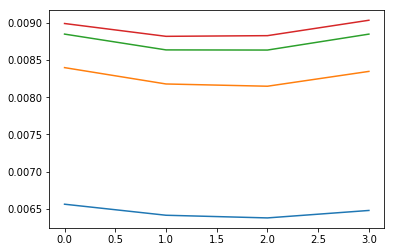

2R
[[ 0.00417981  0.00413156  0.00411529  0.00415306]
 [ 0.00658612  0.00647557  0.00647335  0.0066109 ]
 [ 0.0077497   0.0075946   0.00758954  0.0077473 ]
 [ 0.00829161  0.00812295  0.00812272  0.00828159]]


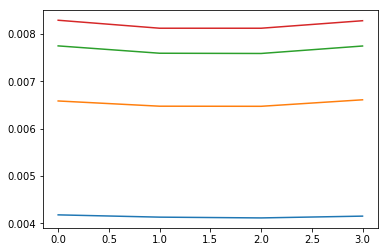

3L
[[ 0.00677058  0.00663554  0.00659466  0.00668295]
 [ 0.00809817  0.00793958  0.0079166   0.00808367]
 [ 0.0087824   0.00858735  0.00857734  0.00877408]
 [ 0.00853908  0.00830244  0.00826466  0.00851447]]


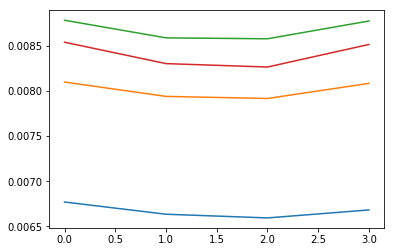

3R
[[ 0.00530286  0.0052037   0.0051805   0.0052434 ]
 [ 0.00737866  0.00723865  0.00722006  0.00735924]
 [ 0.00779638  0.00764822  0.00763919  0.00780046]
 [ 0.00797297  0.00781001  0.00775103  0.00790268]]


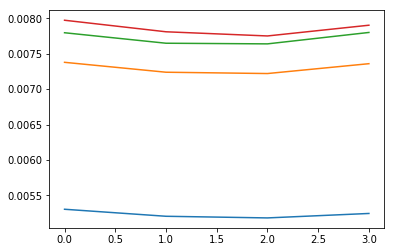

In [155]:
for chrom in chroms:
    print(chrom)
    plt.plot(pi_dict[chrom].T)
    print(pi_dict[chrom])
    plt.show()

In [ ]:
r_means = 

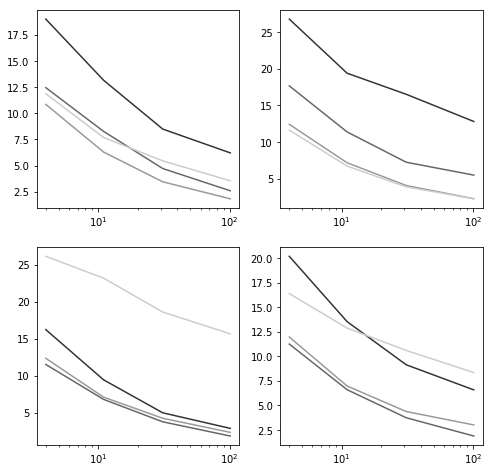

In [158]:
plt.figure(figsize=(8,8))
for i_chr, chrom in enumerate(chroms):
    MI = mi_dict[chrom]
    PI = pi_dict[chrom]
    for i in range(n_bins):
        r = r_bins[i]+0.5
        #r = r_means[i]

        ax = plt.subplot(2,2,i_chr+1)
        plt.semilogx(np.array(d_list)+1, MI[i,:]/PI[i,:]**2, color=str(r/5))

        #ax = plt.subplot(3,1,2)
        #plt.semilogx((np.array(d_list)+1)*r, MI[i,:]/PI[i,:]**2, color=str(r/5))

        #ax = plt.subplot(3,1,3)
        #plt.semilogx(a*(np.array(d_list)+1)*r*np.mean(PI[i,:]), MI[i,:]/PI[i,:]**2, color=str(r/5))
plt.show()

This looks wrong. Check the pointwise:

2L
r = 1.0


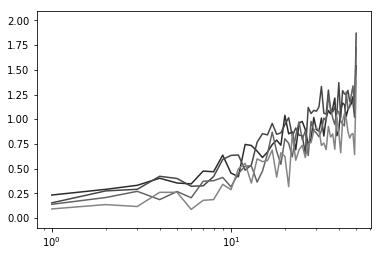

r = 2.0


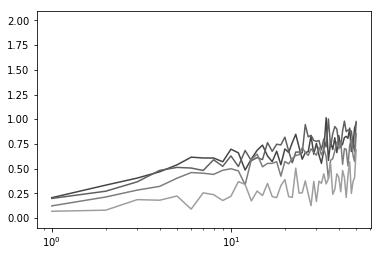

r = 3.0


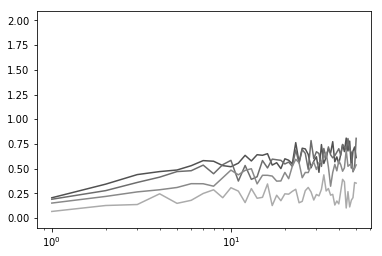

r = 4.0


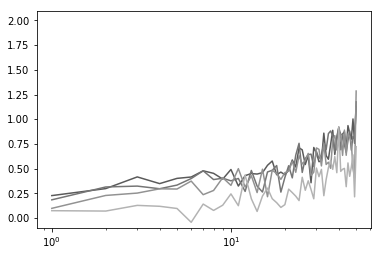

2R
r = 1.0


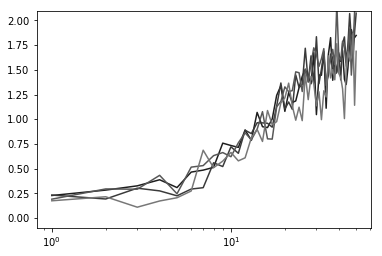

r = 2.0


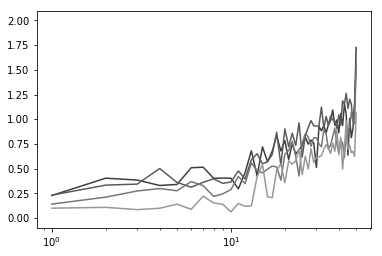

r = 3.0


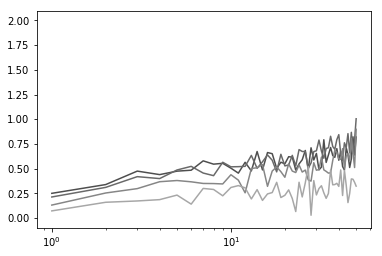

r = 4.0


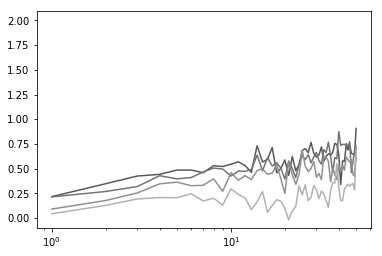

3L
r = 1.0


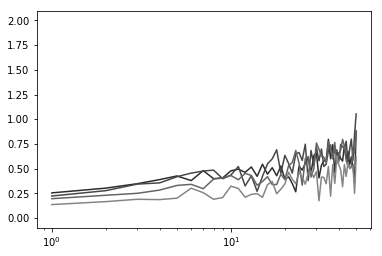

r = 2.0


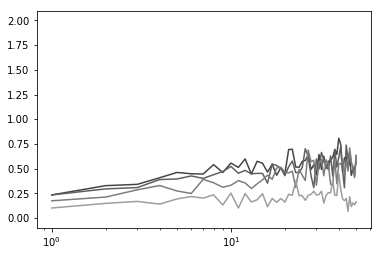

r = 3.0


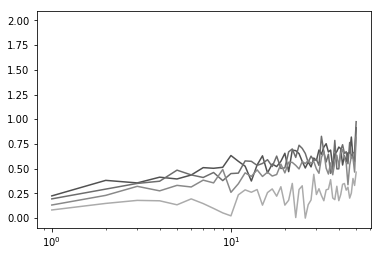

r = 4.0


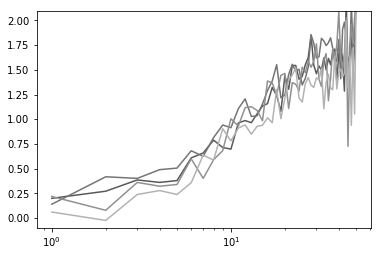

3R
r = 1.0


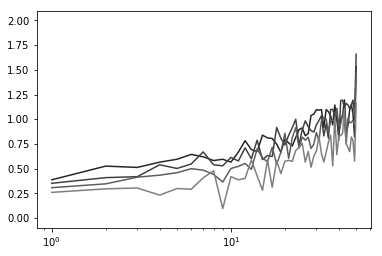

r = 2.0


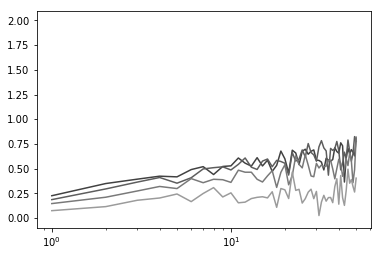

r = 3.0


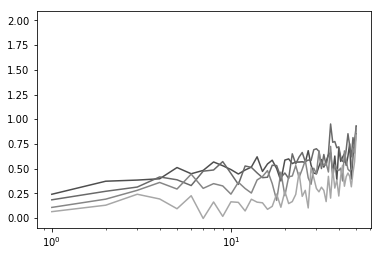

r = 4.0


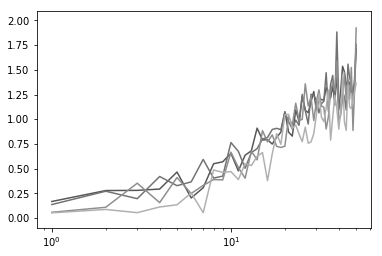

In [162]:
for chrom in chroms:
    print(chrom)
    PMI = pmi_dict[chrom]
    PI = pi_dict[chrom]
    PMI_nan = np.copy(PMI)
    PMI_nan[np.isinf(PMI)] = np.nan
    
    for i in range(n_bins):
        print("r =", r_bins[i]+0.5)
        for j in range(len(d_list)):
            d_scaled = a*(d_list[j]+1)*(r_bins[i]+0.5)*PI[i,j]
            c = str((np.log10(d_scaled)+2)/4)
            plt.semilogx(np.nanmean(PMI_nan[i,j,0:,0:], axis=1), color=c)
        plt.ylim([-0.1,2.1])
        plt.show()

It looks like something is getting scrambled here.

# SFS covariance matrices

In [195]:
from scipy.stats import hmean

In [201]:
w_locus = 100
M1 = np.zeros(max_maf+1)
M2 = np.zeros((max_maf+1,max_maf+1))
in_bin = np.logical_or(in_bins[1], in_bins[2])
data = maf_loci[in_bin, :].reshape((-1, w_locus))
n_sites = np.zeros(n_windows*w_locus*dw)
for i in range(data.shape[0]):
    non_nan = ~np.isnan(data[i])
    n_sites[i] = np.count_nonzero(non_nan)
    if n_sites[i] == 0:
        continue
    local_sfs = np.histogram(data[i][non_nan], np.arange(max_maf + 2))[0]/n_sites[i]
    M1 += local_sfs
    M2 += local_sfs[:,None]*local_sfs[None,:]
M1 /= np.count_nonzero(n_sites)
M2 /= np.count_nonzero(n_sites)

In [216]:
lbar = hmean(n_sites[n_sites>0])
M1 *= lbar
M2 *= lbar**2
print(lbar)

56.5586171289


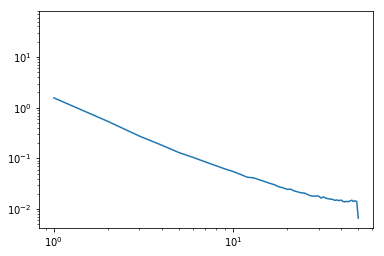

In [217]:
plt.loglog(M1)
plt.show()

In [212]:
M1_sq = M1[:,None] * M1[None,:]
COV = (M2 - M1_sq) / M1_sq
#np.fill_diagonal(COV, 0)

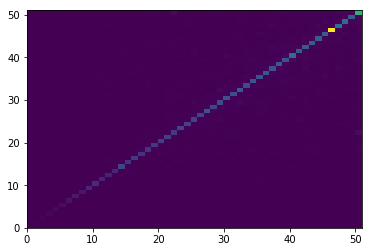

In [213]:
plt.pcolor(COV)
plt.show()

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


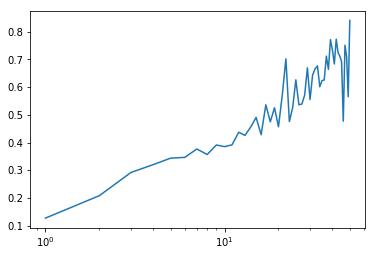

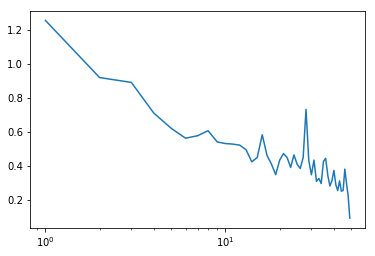

In [222]:
COV_sub = COV[1:,1:]
np.fill_diagonal(COV_sub,np.nan)
A = np.nanmean(COV_sub,axis=1)
B = np.zeros(50)
for i in range(50):
    B[i] = np.nanmean(COV_sub.diagonal(offset=i+1))
plt.semilogx(np.arange(1,51),A)
plt.show()
plt.semilogx(np.arange(1,51),B)
plt.show()